In [12]:

import os
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

from scipy.stats import describe

import matplotlib.colors as colors

from scipy import signal

from scipy.stats import probplot
from scipy.stats import normaltest
from joblib import dump, load

from sklearn.metrics import mean_squared_error


In [13]:
def extract_features(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
#     amps /= 0.01
    amps = lin_log_interp(amps)
    
    _,minmax,mean,variance,skewness,kurtosis = describe(values,axis=1)
    mean = mean[...,np.newaxis]
    variance = variance[...,np.newaxis]
    skewness = skewness[...,np.newaxis]
    kurtosis = kurtosis[...,np.newaxis]
    
    sampleRMS = np.sqrt(1 / values.shape[0] * np.sum((values - np.repeat(mean,values.shape[1],axis=1).reshape(mean.shape[0],values.shape[1]))**2,axis=1))
    
    sampleRMS = sampleRMS[...,np.newaxis]
    
    print(mean.shape,variance.shape,skewness.shape,kurtosis.shape,sampleRMS.shape)
    stats = np.hstack((mean,variance,skewness,kurtosis,sampleRMS))
    
    return amps,stats


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [14]:
DoE_test = np.loadtxt('Experiment-3-Data/DoE_test_pruned.txt',delimiter=',')
DoE_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

X_train_original,stats_train_original = extract_features(X_train,)
X_test_original,stats_test_original = extract_features(X_test,)

stats_train_unhealthy = stats_train_original[first_good_train:,:]
stats_valid_unhealthy = stats_test_original[first_good_test:,:]
stats_train_healthy = stats_train_original[:first_good_train,:]
stats_valid_healthy = stats_test_original[:first_good_test,:]


X_train_unhealthy = X_train_original[first_good_train:,:]
X_valid_unhealthy = X_test_original[first_good_test:,:]
X_train_healthy = X_train_original[:first_good_train,:]
X_valid_healthy = X_test_original[:first_good_test,:]

DoE_train_healthy = DoE_train[:first_good_train,:]
DoE_train_unhealthy = DoE_train[first_good_train:,:]
DoE_test_healthy = DoE_test[:first_good_test,:]
DoE_test_unhealthy = DoE_test[first_good_test:,:]


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

stats_train = np.vstack((stats_train_healthy,stats_train_unhealthy))
stats_valid = np.vstack((stats_valid_healthy,stats_valid_unhealthy))

Y_train = XY_train[:,-1]
Y_valid = XY_valid[:,-1]
columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']

X = []
X.append(X_train_healthy)
X.append(X_valid_healthy)
X.append(X_train_unhealthy)
X.append(X_valid_unhealthy)

DoE = []
DoE.append(DoE_train_healthy)
DoE.append(DoE_test_healthy)
DoE.append(DoE_train_unhealthy)
DoE.append(DoE_test_unhealthy)

stats = []
stats.append(stats_train_healthy)
stats.append(stats_valid_healthy)
stats.append(stats_train_unhealthy)
stats.append(stats_valid_unhealthy)
freqs = np.linspace(0,10000,2048)


(306, 1) (306, 1) (306, 1) (306, 1) (306, 1)
(151, 1) (151, 1) (151, 1) (151, 1) (151, 1)


In [15]:
X_train_original.shape

(306, 2049)

In [16]:
def fit_statistics(y_true, y_pred):

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    # Null hypothesis: tool is healthy
    # Positive: Tool is unhealthy
    # Negative: Tool is healthy
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    
    # False positive: tool is actually healthy but classified as unhealthy
    # | - | X |
    # | - | - |
    false_positive = conf_matrix[0,1]
    
    # False negative: tool is actually unhealthy but classified as healthy
    # | - | - |
    # | X | - |
    false_negative = conf_matrix[1,0]
    
    # Precision: Quantifies false positives
    # Recall: Quantifies false negatives
    
    if true_positive == 0 and false_positive == 0.:
        precision = 0.
    else:
        precision = true_positive / (true_positive + false_positive)
    
    if true_positive == 0. and false_negative == 0.:
        recall = 0.
        true_positive_rate = 0.
    else:
        recall = true_positive / (true_positive + false_negative)
        true_positive_rate = true_positive / (true_positive + false_negative)

    if true_negative == 0. and false_positive == 0.:
        true_negative_rate = 0.
    else:
        true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
    
    return balanced_accuracy, true_positive_rate, true_negative_rate, precision, recall
 


In [17]:
precision_recall = np.load('data/precision_recall_noscaling_noDoE.npy',allow_pickle=True)

In [18]:
train_precision = precision_recall[...,0]
train_recall = precision_recall[...,1]
valid_precision = precision_recall[...,2]
valid_recall = precision_recall[...,3]

train_score = 2 * np.nan_to_num((train_precision * train_recall) / (train_precision + train_recall))
valid_score = 2 * np.nan_to_num((valid_precision * valid_recall) / (valid_precision + valid_recall))

# train_score = np.sum(precision_recall[...,:2]**2,axis=-1)
# valid_score = np.sum(precision_recall[...,2:]**2,axis=-1)
combined_score = (valid_score)**2 + (train_score)**2
combined_score /= 2
freqs = np.linspace(0,10000,2048)

In [19]:
print(combined_score.flatten()[np.argmax(combined_score)])
print(train_score.flatten()[np.argmax(combined_score)])
print(valid_score.flatten()[np.argmax(combined_score)])
# print(np.argmax(combined_score))
# print(np.argmax(combined_score) % combined_score.shape[1])
# print(int(np.floor(np.argmax(combined_score) / combined_score.shape[1])))
# print(valid_score[29,np.argmax(combined_score) % combined_score.shape[1]])
# print(train_score[9,245])

best_pca = int(np.floor(np.argmax(combined_score) / combined_score.shape[1])) + 2
best_fft = np.argmax(combined_score) % combined_score.shape[1] + 2

print(best_pca)
print(best_fft)

0.9574669187145557
1.0
0.9565217391304347
31
301


In [9]:
pca = PCA(n_components=0.9)
pca.fit(np.hstack((XY_train[:,:512],DoE_train[:,:2])))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

In [10]:
pca.n_components_

135

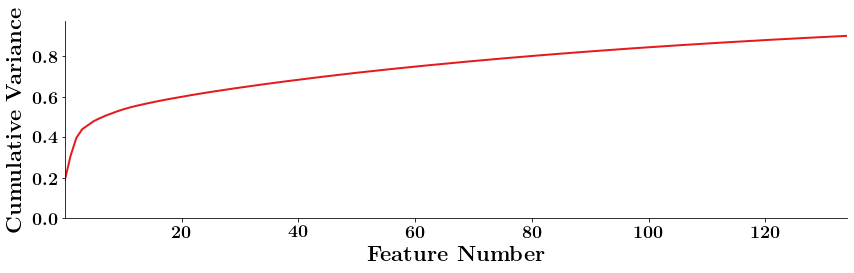

In [11]:
# combine the responses and labels to put on our 2D plot
responses = np.vstack((cumulative_variance))
labels = [r'']

# Create a 2D plot
genplt.generate_plot(np.arange(cumulative_variance.shape[0]), # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Feature Number',# X - axis label
              r'Cumulative Variance',   # Y - axis label
              filename='Test_PCA_Decomposition',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
              log_y=False,
              ymin=0.05,
              transparent=True,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='svg'
             )



In [12]:
def plot_scores(score,delta_f,filename='scores',template='publication'):
    
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(12,6))
    else:
        fig = plt.figure()    
        
    yi = np.arange(-0.0, score.shape[0]) + 2
    xi = (np.arange(0.0,score.shape[1]) + 2) * delta_f

    X, Y = np.meshgrid(xi, yi)

#     plt.figure(figsize=(12,4))
    ax = plt.gca()
    plt.pcolormesh(X,Y,score,cmap='cividis',norm=colors.Normalize(vmin=np.amin(score),vmax=np.amax(score)))
    cbar = plt.colorbar()
    cbar.set_label(r'\textbf{Normalized Score}', rotation=270,labelpad=20)
    plt.ylabel(r'\textbf{PCA Dimensions}', labelpad=5,fontsize=22)
    plt.xlabel(r'\textbf{Spectral Bandwidth (Hz)}', labelpad=5,fontsize=22)
    
    plt.tight_layout(pad=1.2)
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    

def box_plot_compare(data,labels,legend,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=None,template='publication',
             xtickpad=5,showfliers=False,legend_loc='best',max_cutoff=0,min_cutoff=0,plot_type='violin'):
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
        
    position = [i+1 for i in range(len(data))]
    tickPositions = []
    phantomLines = []
        
    for i in range(data[0].shape[1]):
        
        thisData = [data[j][:,i] for j in range(len(data))]

        bp = plt.boxplot(thisData,
                        positions=position,
                        showfliers=showfliers,
                        patch_artist=True,
                        meanline=False,
                        notch=False,
                        medianprops={'color':'black',
                                     'linewidth':2},
                        whiskerprops={'linewidth':2},
                        capprops={'linewidth':2},
                        widths=0.75)

        for counter,patch in enumerate(bp['boxes']):
            # change outline color
            patch.set(color=colors[counter], linewidth=2)
            patch.set_facecolor(colors[counter])

            if i == 0:
                line, = plt.plot([1,1],color=colors[counter])
                phantomLines.append(line)
            
        tickPositions.append(np.mean(position))    
        position = [position[i] + len(data) + 1 for i in range(len(position))]
            
    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    ax.legend(tuple(phantomLines),tuple(legend),loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    [phantomLines[i].set_visible(False) for i in range(len(phantomLines))]
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    

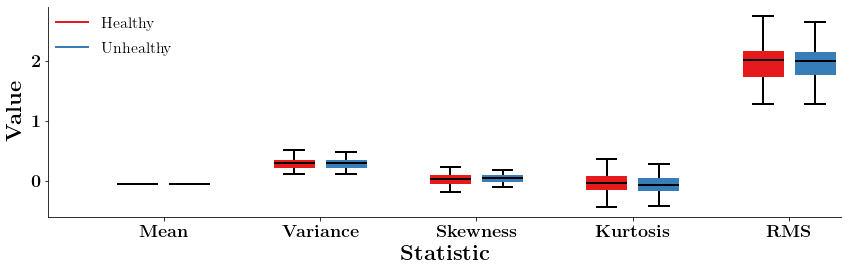

In [13]:
box_plot_compare([stats[0],stats[2]],['Mean','Variance','Skewness','Kurtosis','RMS'],['Healthy','Unhealthy'],savefig=True,filename='Time-Domain_Full-Compare',
         template='wide',xlabel='Statistic',color_order=np.zeros(6).astype(int),ylabel='Value',
         showfliers=False,legend_loc='upper left',max_cutoff=2,plot_type='box',
         log_y=False)

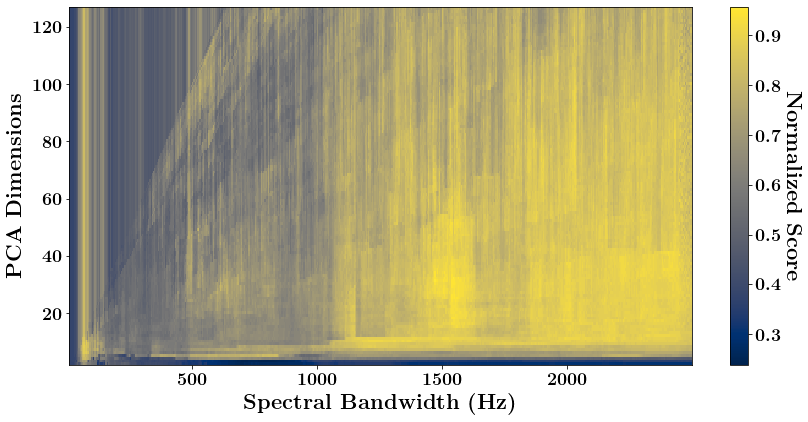

In [14]:
plot_scores(combined_score,freqs[1],filename='classification-compare-v1',template='presentation')